### MOOC-HPFEM: Template notebook to be used to complete the assignments



The present notebook is meant to be a template for you to use while doing the assignments of the course. The first cell is meant to be run as-is and takes care of configuring the environment for you. The second cell is empty by default and is where you are supposed to paste the code you are given in the assignments so that you can modify and run it.

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *


import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 
import numpy as np 
import logging ; 
logging.getLogger('FFC').setLevel(logging.WARNING) 
set_log_active(False)

def plot_compact(u, t, stepcounter): # Compact plot utility function
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(u,Q)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    ax1 = plt.subplot(1, 2, 1)
    fenicsplot.mplot_function(ax1,uEuclidnorm) 
    plt.title("Wave") # Plot norm of solution

    #plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    plt.triplot(fenicsplot.mesh2triang(mesh))
    plt.title("Mesh") 
    plt.suptitle('Wave - t: %f' %(t))
    plt.tight_layout(); 
    clear_output(wait=True) 
    dpl = display(pl);
  
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)



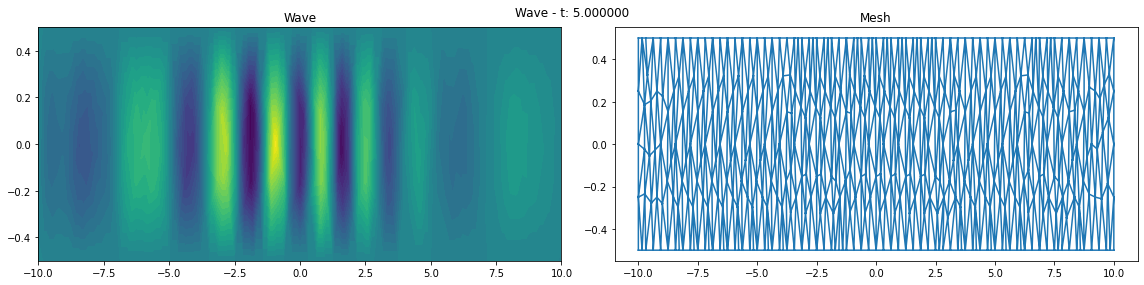

In [47]:
# Define domain and mesh
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
Qe = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, Qe * Qe) 
h = CellDiameter(mesh) 
(p, q) = TestFunctions(W); 
w = Function(W); 
(u, v) = (w[0], w[1]);
u0 = Function(Q); 
v0 = Function(Q);

# Time interval and time step
t, T = 0., 5.;
k = 0.05;
a = 10;

# Define the Dirichlet boundary   
def boundary(x, on_boundary):                                                                                                                                                                                                 
    return on_boundary

# Initial solution
option = 1;
if option==0:
    ue = Expression("((1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh,degree=2);
    ve = Expression("(2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh,degree=2)
if option==1:
    ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh,degree=2);
    ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh,degree=2)

# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;


# Time-stepping loop    
while t < T:
    # Weak form of wave equation
    vm = theta*v + (1.0-theta)*v0;
    um = theta*u + (1.0-theta)*u0;
    ru=(u-u0)/k*p*dx - vm*p*dx
    rv=(v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
    r = ru + rv;
    ue.t = t;
    ve.t = t;
    
    # Solve the wave equation (one time step)
    solve(r==0, w, bcs);
    
    # Visualize the solution
    pl, ax = plt.subplots()
    plot_compact(u,t,0) 
    plt.close();
    
    # Shift to next timestep                                                     
    u0 = project(u, Q);
    v0 = project(v, Q);
    t += k;